In [1]:
import os
import re
import json
import torch
import torchaudio
import evaluate
import numpy as np
import pandas as pd
from datasets import Dataset, Audio
from transformers import (
    Wav2Vec2CTCTokenizer,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    Wav2Vec2ForCTC
)
from transformers.training_args import TrainingArguments
from transformers.trainer import Trainer

# Check for CUDA availability and print device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


c:\Users\Joaquin\Documents\School\College 4th Year\1st Semester\6CSTUDY2\Models\Pamagsalin_Model_Training\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: NVIDIA GeForce RTX 4070 Laptop GPU


# --- Configuration ---
# IMPORTANT: Update these paths for Kapampangan training

In [2]:
VALIDATED_DATA_FOLDER = 'data/Cleaned_Audio_Files'  # The folder with Kapampangan audio and transcriptions
MODEL_OUTPUT_DIR = './kapampangan_wav2vec2_model'  # Directory to save the trained model
BASE_MODEL = "facebook/wav2vec2-large-xlsr-53"  # Base model for fine-tuning


# --- 1. Load the Dataset ---

In [3]:
def load_custom_dataset(data_folder):
    """Loads the dataset from the metadata.csv file."""
    metadata_path = os.path.join(data_folder, "metadata.csv")
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(
            f"metadata.csv not found in {data_folder}. "
            "Please ensure you have run the prepare_kapampangan_dataset.py script first."
        )
    dataset_df = pd.read_csv(metadata_path)
    # Convert DataFrame to Hugging Face Dataset object
    custom_dataset = Dataset.from_pandas(dataset_df)
    return custom_dataset

# --- 2. Create Vocabulary for Kapampangan ---

In [4]:
def create_vocabulary(data):
    """
    Extracts all unique characters from the Kapampangan transcription column
    and creates a vocabulary file.
    """
    # Regex to ignore punctuation/symbols
    chars_to_ignore_regex = r"[\,\?\.\!\-\;\:\“\”\‘\’\'\"\%\[\]\(\)\…]"

    def extract_all_chars(batch):
        all_text = " ".join(batch["transcription"])
        # Normalize and clean
        all_text = re.sub(chars_to_ignore_regex, '', all_text).lower()
        return {"all_text": [all_text]}

    # Concatenate all transcriptions into a single string
    vocab_result = data.map(
        extract_all_chars,
        batched=True,
        batch_size=-1,
        keep_in_memory=True,
        remove_columns=data.column_names
    )

    all_text = " ".join(vocab_result["all_text"])
    # Sorted ensures reproducibility
    vocab_list = sorted(list(set(all_text)))

    vocab_dict = {v: k for k, v in enumerate(vocab_list)}

    # Add special tokens for CTC
    if " " in vocab_dict:
        vocab_dict["|"] = vocab_dict.pop(" ")
    else:
        vocab_dict["|"] = len(vocab_dict)

    vocab_dict["[UNK]"] = len(vocab_dict)
    vocab_dict["[PAD]"] = len(vocab_dict)

    # Save the vocabulary
    vocab_path = os.path.join(MODEL_OUTPUT_DIR, 'vocab.json')
    os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
    with open(vocab_path, 'w', encoding='utf-8') as vocab_file:
        json.dump(vocab_dict, vocab_file, ensure_ascii=False, indent=2)

    print(f"✅ Vocabulary created and saved to {vocab_path}")
    print(f"📊 Vocabulary size: {len(vocab_dict)}")
    return vocab_path


# --- 3. Preprocess the Data ---

In [5]:
def preprocess_data(dataset, processor):
    """
    Prepares the dataset for training:
    1. Loads and resamples audio.
    2. Tokenizes Kapampangan transcriptions.
    """
    import librosa
    import soundfile as sf

    total_before = len(dataset)
    
    def prepare_dataset(batch):
        try:
            audio_path = batch["file_path"]
            waveform, sr = torchaudio.load(audio_path)

            if sr != 16000:
                resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
                waveform = resampler(waveform)

            # Convert waveform tensor to numpy array and flatten
            audio_array = waveform.squeeze().numpy()

            batch["input_values"] = processor(audio_array, sampling_rate=16000).input_values[0]
            batch["input_length"] = len(batch["input_values"])

            with processor.as_target_processor():
                batch["labels"] = processor(batch["transcription"]).input_ids
            return batch

        except Exception as e:
            print("Failed to Process")
            print(f"File: {batch.get('file_path', 'Path not found')}")
            print(f"Error: {repr(e)}")  # This will give the actual exception message
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            return None

    # Process each example individually
    processed_examples = []
    for i in range(len(dataset)):
        example = dataset[i]
        processed_example = prepare_dataset(example)
        if processed_example is not None:
            processed_examples.append(processed_example)
    
    # Create a new dataset from processed examples
    from datasets import Dataset
    dataset = Dataset.from_list(processed_examples)
    total_after = len(dataset)
    print(f"Preprocessing complete: {total_after} / {total_before} samples successfully processed.")
    return dataset

# --- 4. Define Metrics and Data Collator ---

In [6]:
class DataCollatorCTCWithPadding:
    """
    Data collator that dynamically pads the inputs and labels for CTC.
    """
    def __init__(self, processor):
        self.processor = processor
        self.padding = "longest"

    def __call__(self, features):
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # Replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

def compute_metrics(pred, processor, wer_metric):
    """Computes Word Error Rate (WER) for evaluation."""
    pred_logits = pred.predictions
    pred_ids = torch.argmax(torch.from_numpy(pred_logits), dim=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.tokenizer.batch_decode(pred_ids)
    label_str = processor.tokenizer.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

# --- Main Training Execution ---

# Step 1: Load data

In [7]:
# Load custom dataset
print("--- Step 1: Loading Kapampangan Dataset ---")
raw_dataset = load_custom_dataset(VALIDATED_DATA_FOLDER)

from datasets import DatasetDict
RANDOM_SEED = 42
SPLIT_RATIO = 0.2  # 20% for evaluation

if len(raw_dataset) > 1:
    dataset_split = raw_dataset.train_test_split(
        test_size=SPLIT_RATIO,
        shuffle=True,
        seed=RANDOM_SEED
    )
    train_dataset = dataset_split['train']
    eval_dataset = dataset_split['test']
    print(f"Dataset split into {len(train_dataset)} training samples and {len(eval_dataset)} evaluation samples.")
else:
    train_dataset = raw_dataset
    eval_dataset = raw_dataset
    print("Warning: Dataset is too small for a split. Evaluating on the training set.")


--- Step 1: Loading Kapampangan Dataset ---
Dataset split into 1990 training samples and 498 evaluation samples.


# Step 2: Create Vocabulary

In [8]:
print("\n--- Step 2: Creating Kapampangan Vocabulary ---")
vocab_path = create_vocabulary(train_dataset)


--- Step 2: Creating Kapampangan Vocabulary ---


Map: 100%|██████████| 1990/1990 [00:00<00:00, 248531.00 examples/s]

✅ Vocabulary created and saved to ./kapampangan_wav2vec2_model\vocab.json
📊 Vocabulary size: 27


# Step 3: Setup Processor (Tokenizer + Feature Extractor)

In [9]:
print("\n--- Step 3: Setting up Processor ---")

tokenizer = Wav2Vec2CTCTokenizer(
    vocab_file=vocab_path,
    unk_token="[UNK]",
    pad_token="[PAD]",
    word_delimiter_token="|"
)

feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=False
)

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

# Save for reuse
processor.save_pretrained(MODEL_OUTPUT_DIR)
print("Processor created and saved.")



--- Step 3: Setting up Processor ---
Processor created and saved.


c:\Users\Joaquin\Documents\School\College 4th Year\1st Semester\6CSTUDY2\Models\Pamagsalin_Model_Training\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Step 4: Preprocess the dataset

In [10]:
print("\n--- Step 4: Preprocessing Data ---")
processed_train_dataset = preprocess_data(train_dataset, processor)
processed_eval_dataset = preprocess_data(eval_dataset, processor)



--- Step 4: Preprocessing Data ---


c:\Users\Joaquin\Documents\School\College 4th Year\1st Semester\6CSTUDY2\Models\Pamagsalin_Model_Training\.venv\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Preprocessing complete: 1990 / 1990 samples successfully processed.
Preprocessing complete: 498 / 498 samples successfully processed.


In [11]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


# Step 5: Setup Trainer

In [15]:
print("\n--- Step 5: Setting up Model and Trainer ---")

# Collator and metric
data_collator = DataCollatorCTCWithPadding(processor=processor)
wer_metric = evaluate.load("wer")

# Load base model
model = Wav2Vec2ForCTC.from_pretrained(
    BASE_MODEL,
    ctc_loss_reduction="mean",
    pad_token_id=tokenizer.pad_token_id,
    vocab_size=len(tokenizer)
)

# Freeze feature extractor first (can unfreeze later if needed)
model.freeze_feature_encoder()

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./wav2vec2_kapampangan",
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=30,
    warmup_ratio=0.1,
    fp16=torch.cuda.is_available(),
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    report_to="none"
)

import numpy as np

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred_str = processor.batch_decode(pred_ids)
    label_ids = np.where(pred.label_ids != -100, pred.label_ids, tokenizer.pad_token_id)
    label_str = processor.batch_decode(label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_train_dataset,   
    eval_dataset=processed_eval_dataset,    
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)






--- Step 5: Setting up Model and Trainer ---


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import torch

print(f"Pytorch ver: {torch.__version__}")
print(f"Cuda avail: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Pytorch ver: 2.6.0+cu124
Cuda avail: True
Device: NVIDIA GeForce RTX 4070 Laptop GPU


# Step 6: Train the model

In [ ]:
print("\n--- Step 6: Starting Kapampangan Training ---")
print("This may take some time depending on your machine and dataset size.")

trainer.train()



--- Step 6: Starting Kapampangan Training ---
This may take some time depending on your machine and dataset size.


  0%|          | 5/3720 [01:09<19:20:24, 18.74s/it]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Plotting

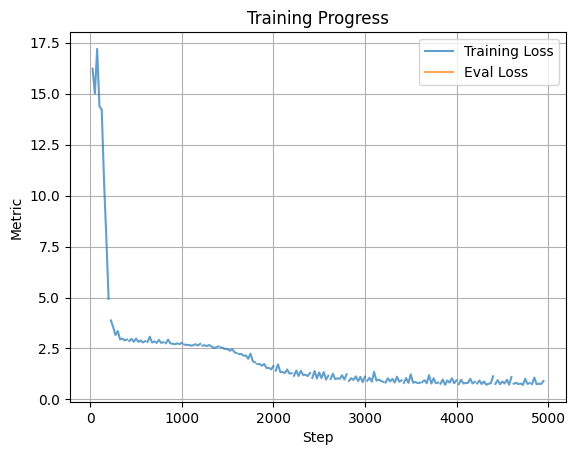

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load trainer log history
logs = pd.DataFrame(trainer.state.log_history)

# Training & Eval loss
plt.plot(logs["step"], logs["loss"], label="Training Loss", alpha=0.7)
if "eval_loss" in logs:
    plt.plot(logs["step"], logs["eval_loss"], label="Eval Loss", alpha=0.7)

# Accuracy
if "accuracy" in logs:
    plt.plot(logs["step"], logs["accuracy"], label="Eval Accuracy", alpha=0.7)

# WER
if "wer" in logs:
    plt.plot(logs["step"], logs["wer"], label="WER", alpha=0.7)

plt.xlabel("Step")
plt.ylabel("Metric")
plt.title("Training Progress")
plt.legend()
plt.grid()
plt.show()


# Step 7: Save the final model

In [ ]:
print("\n--- Step 7: Saving Final Model ---")
trainer.save_model(MODEL_OUTPUT_DIR)
print(f"Training complete! Model saved in: {MODEL_OUTPUT_DIR}")



--- Step 7: Saving Final Model ---
Training complete! Model saved in: ./kapampangan_wav2vec2_model


# Step 8: Evaluate on Evaluation Set

In [ ]:
print("\n--- Step 8: Evaluating on Validation Set ---")

# Optionally reload model
# model = Wav2Vec2ForCTC.from_pretrained(MODEL_OUTPUT_DIR).to(device)

predictions = trainer.predict(processed_eval_dataset)
metrics = compute_metrics(predictions)


print(f"Validation WER: {metrics['wer']:.4f}")



--- Step 8: Evaluating on Validation Set ---


c:\Users\Joaquin\Documents\School\College 4th Year\1st Semester\6CSTUDY2\Models\Pamagsalin_Model_Training\.venv\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
100%|██████████| 249/249 [00:59<00:00,  4.20it/s]


Validation WER: 0.7583


# Show Sample Predictions

In [ ]:
from random import sample

print("\n--- Sample Predictions ---")
pred_ids = torch.argmax(torch.from_numpy(predictions.predictions), dim=-1)
decoded_preds = processor.batch_decode(pred_ids)
decoded_labels = processor.batch_decode(predictions.label_ids, group_tokens=False)

for i in sample(range(len(decoded_preds)), 5):
    print(f"[{i+1}]")
    print(f"Kapampangan (Predicted) : {decoded_preds[i]}")
    print(f"Kapampangan (Reference) : {decoded_labels[i]}")
    print("-" * 40)



--- Sample Predictions ---
[328]
Kapampangan (Predicted) : [UNK]oka ring pipanganan ing puuntalan mu[UNK] neng bisa kang magan maparasa pamangan[UNK]w
Kapampangan (Reference) : [UNK]okaring pipanganan ing pupuntalan mu neng bisa kang mangang maparas a pamangan[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]
----------------------------------------
[58]
Kapampangan (Predicted) : [UNK]aralas kaming mamult basura ban[UNK] makasaup keng pamagli ing ap keng kapaligiran[UNK]w
Kapampangan (Reference) : [UNK]aralas kaming mamulut basura ban makasaup keng pamaglingap keng kapaligiran[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][